# Results analysis

#### dataset Loading and options 

In [ ]:
from datasets import Dataset,load_dataset
import pandas as pd
import seaborn as sb

#dataset_split_name ="simpleLLM_benchmark_llama3.18binstant_t_0.7" 
#dataset_split_name ="simpleLLM_benchmark_llama3.370bversatile_t_0.7"
#dataset_split_name ="simpleLLM_benchmark_deepseekr17b_t_0.7"
dataset_split_name ="simpleLLM_benchmark_mixtral8x7b32768_t_0.7" 

dataset_split = [dataset_split_name][0]

dataset = load_dataset("CharlyR/varbench-evaluation", dataset_split, split="tikz")
import os

result_path = os.path.join("results",dataset_split_name)
not os.path.exists("results/"+dataset_split_name) and os.mkdir("results/"+dataset_split_name)


Generating tikz split: 100%|██████████| 50/50 [00:00<00:00, 8410.14 examples/s]


In [91]:
dataset

Dataset({
    features: ['id', 'code', 'instruction', 'result_description', 'difficulty', 'patch', 'code_solution', 'image_solution', 'image_input', 'original_predictions', 'predictions', 'images_result', 'parsing_score', 'compiling_score', 'predictions_patches', 'TERPatchMetric', 'ChrfMetric', 'MSSSIMMetric', 'BleuMetric', 'ClipTextMetric', 'LineMetric', 'ClipImageMetric', 'PSNRMetric', 'ChrfPatchMetric', 'TERMetric', 'MSEMetric', 'BleuPatchMetric', 'PatchMetric', 'LPIPSMetric', 'FeatureMatchMetric', 'CrystalBleuPatchMetric', 'CrystalBleuMetric'],
    num_rows: 50
})

## Best prediction computation

---
Best prediction is computed but not used for now, passk list is flattened later and metrics computed on all of them

In [92]:
from results_utils import MetricPolicy
import pandas as pd

computed_metrics_names = [
    metric_name
    for metric_name in dataset.column_names
    if metric_name.endswith("Metric") and not metric_name.startswith("best")
]


# each metric is computed on list of predictions of length pass@k, and yields a list of list of result of the same length.
# from that list[list[float]](the results), we get the best result according to a certain policy(here the arithmetic mean)
subset = dataset.map(
    MetricPolicy.compute_best_prediction,
    fn_kwargs={"computed_metrics_names": computed_metrics_names},
)

scores = {
    metric_name: sum(subset[f"best_{metric_name}"]) / len(subset)
    for metric_name in computed_metrics_names
}
scores["var_score"] = sum(subset["var_score"]) / len(subset)
scores
result_df:pd.DataFrame = subset.to_pandas()

Map: 100%|██████████| 50/50 [00:00<00:00, 1449.32 examples/s]


## Pre-Filtering

In [93]:
# filtering by having a result
filtered_df = result_df[result_df["index_best_prediction"] != -1]

# ordering by text metrics
text_metrics = [
    metric_name
    for metric_name in computed_metrics_names
    if any((substring in metric_name) for substring in ["TER", "Line", "Bleu", "Chrf","Patch"])
]
other_metrics = list(set(computed_metrics_names) - set(text_metrics))
ordered_metrics = text_metrics + other_metrics
filtered_df = filtered_df[ordered_metrics + ["id", "difficulty"]]
filtered_df

,TERPatchMetric,ChrfMetric,BleuMetric,LineMetric,ChrfPatchMetric,TERMetric,BleuPatchMetric,PatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,MSEMetric,FeatureMatchMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,id,difficulty
0,[51.449276],[98.560135],[96.04783],[0.0],[5.3410153],[96.04863],[0.06101686],[0.0],[0.06022831],[94.11079],[97.572784],[99.85442],[71.42857],[46.868694],[98.28234],[22.711433],[99.886734],donkey_higher_mane,hard
1,[61.70213],[96.468796],[93.794716],[0.0],[61.620274],[93.84615],[50.394688],[0.0],[45.54385],[91.152084],[95.11164],[99.693115],[93.24324],[44.17076],[97.34933],[27.249828],[99.62338],chimpanzee_squint_crosseyes,medium
2,[95.55556],[99.44997],[98.91715],[100.0],[96.31156],[99.16318],[89.31037],[0.0],[88.22937],[98.27843],[99.85424],[99.99295],[79.03226],[48.69009],[99.90251],[27.267843],[99.932144],bee_red_stripes,easy
3,[51.898735],[95.919556],[84.272385],[0.0],[12.950547],[76.34069],[0.19718786],[0.0],[0.19610037],[83.76824],[99.64016],[99.992546],[89.13043],[54.845272],[99.10131],[24.504738],[99.023544],shark_no_teeth,easy
4,[52.25225],[89.14324],[86.54742],[0.0],[20.63061],[80.097084],[2.1823819],[0.0],[1.7423209],[85.48761],[96.47926],[99.88932],[61.29032],[46.941143],[95.68011],[26.332657],[96.35184],shark_other_set_pectoral_fin,hard
5,[62.962963],[98.316475],[98.59731],[100.0],[77.056854],[98.4],[47.229332],[0.0],[44.856766],[97.87205],[97.43857],[99.67518],[75.80645],[45.419075],[96.34445],[25.463772],[98.35478],dog_red_eyes,easy
7,[50.0],[97.66371],[93.29816],[100.0],[65.147964],[91.18774],[30.894087],[0.0],[24.99283],[88.973946],[93.33563],[99.260185],[33.73494],[41.7646],[97.527664],[27.430788],[98.86016],squid_bigger_eyes,medium
8,[71.014496],[97.83453],[96.30105],[100.0],[87.72034],[97.23757],[63.917538],[0.0],[63.498093],[93.07527],[80.61351],[99.34083],[45.333332],[38.876728],[93.722855],[26.844011],[98.467545],chimpanzee_blue_fur,easy
9,[50.0],[97.76128],[94.18049],[0.0],[15.0388365],[94.78528],[0.43558773],[0.0],[0.34987924],[91.66908],[95.858604],[99.78598],[66.27907],[43.14003],[97.23788],[26.125486],[99.796],cow_longer_horns,medium
11,[50.0],[92.83233],[76.39091],[100.0],[62.52854],[83.5249],[23.51041],[0.0],[21.148197],[68.50952],[82.822586],[98.363556],[24.444445],[38.80005],[86.63744],[23.283438],[99.01405],cat_big,medium


In [94]:
from results_utils import flatten_metrics
#flattening the pass arrays
flatten_df = flatten_metrics(filtered_df,ordered_metrics)

In [95]:
flatten_df

,TERPatchMetric,ChrfMetric,BleuMetric,LineMetric,ChrfPatchMetric,TERMetric,BleuPatchMetric,PatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,MSEMetric,FeatureMatchMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric,difficulty,id
0,51.449276,98.560135,96.047829,0.000000,5.341015,96.048630,0.061017,0.0,0.060228,94.110786,97.572784,99.854424,71.428574,46.868694,98.282341,22.711433,99.886734,hard,donkey_higher_mane
1,61.702129,96.468796,93.794716,0.000000,61.620274,93.846153,50.394688,0.0,45.543850,91.152084,95.111641,99.693115,93.243240,44.170761,97.349327,27.249828,99.623383,medium,chimpanzee_squint_crosseyes
2,95.555557,99.449966,98.917152,100.000000,96.311562,99.163177,89.310371,0.0,88.229370,98.278427,99.854240,99.992950,79.032257,48.690090,99.902512,27.267843,99.932144,easy,bee_red_stripes
3,51.898735,95.919556,84.272385,0.000000,12.950547,76.340691,0.197188,0.0,0.196100,83.768242,99.640160,99.992546,89.130432,54.845272,99.101311,24.504738,99.023544,easy,shark_no_teeth
4,52.252251,89.143242,86.547417,0.000000,20.630610,80.097084,2.182382,0.0,1.742321,85.487610,96.479263,99.889320,61.290321,46.941143,95.680107,26.332657,96.351837,hard,shark_other_set_pectoral_fin
5,62.962963,98.316475,98.597313,100.000000,77.056854,98.400002,47.229332,0.0,44.856766,97.872047,97.438568,99.675179,75.806450,45.419075,96.344452,25.463772,98.354782,easy,dog_red_eyes
6,50.000000,97.663712,93.298157,100.000000,65.147964,91.187737,30.894087,0.0,24.992830,88.973946,93.335632,99.260185,33.734940,41.764599,97.527664,27.430788,98.860161,medium,squid_bigger_eyes
7,71.014496,97.834534,96.301048,100.000000,87.720337,97.237572,63.917538,0.0,63.498093,93.075272,80.613510,99.340828,45.333332,38.876728,93.722855,26.844011,98.467545,easy,chimpanzee_blue_fur
8,50.000000,97.761276,94.180489,0.000000,15.038836,94.785278,0.435588,0.0,0.349879,91.669083,95.858604,99.785980,66.279068,43.140030,97.237877,26.125486,99.795998,medium,cow_longer_horns
9,50.000000,92.832329,76.390907,100.000000,62.528542,83.524902,23.510410,0.0,21.148197,68.509521,82.822586,98.363556,24.444445,38.800049,86.637444,23.283438,99.014053,medium,cat_big


## Passing rate

In [96]:
result_df.iloc[0]

id                                                            donkey_higher_mane
code                           \documentclass[tikz,border=5]{standalone}\n\us...
instruction                    Make the mane of the donkey go upward a little...
result_description                       A donkey with a high mane over its head
difficulty                                                                  hard
patch                          @@ -61,2 +61,2 @@\n-  to [bend left]  ++( 16, ...
code_solution                  \documentclass[tikz,border=5]{standalone}\n\us...
image_solution                 {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
image_input                    {'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
original_predictions           [```\n\documentclass[tikz,border=5]{standalone...
predictions                    [\documentclass[tikz,border=5]{standalone}\n\u...
images_result                  [{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIH...
parsing_score               

In [97]:
def compute_pass(row):
    row["images_result"] = len(row["images_result"])>0
    return row
pass_dataset = result_df[["difficulty","id","images_result"]].apply(compute_pass,axis=1)
pass_dataset= pass_dataset.rename({"images_result":"pass"},axis=1)

In [98]:
pass_dataset

,difficulty,id,pass
0,hard,donkey_higher_mane,True
1,medium,chimpanzee_squint_crosseyes,True
2,easy,bee_red_stripes,True
3,easy,shark_no_teeth,True
4,hard,shark_other_set_pectoral_fin,True
5,easy,dog_red_eyes,True
6,easy,monkey_sad,False
7,medium,squid_bigger_eyes,True
8,easy,chimpanzee_blue_fur,True
9,medium,cow_longer_horns,True


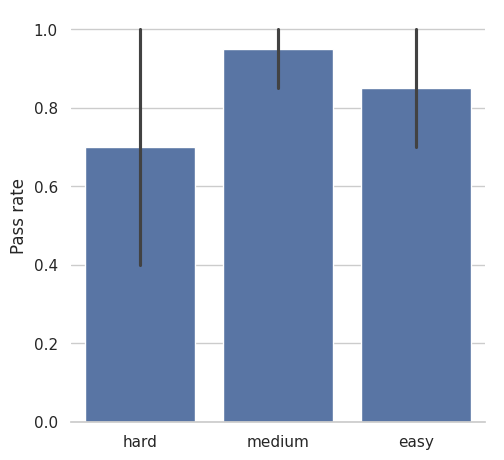

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=pass_dataset, kind="bar",
    x="difficulty", y="pass"
)
g.despine(left=True)
g.set_axis_labels("", "Pass rate")
g.legend.set_title("")
plt.savefig(os.path.join(result_path,"pass_rate_difficulty.png"), dpi=300, bbox_inches="tight")


## no subcategories

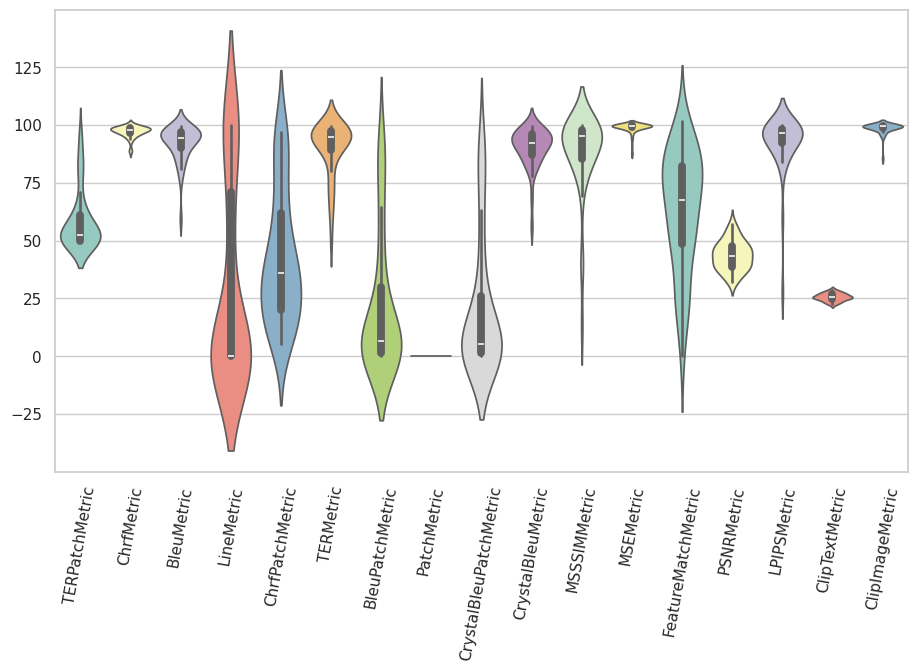

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))
plt.xticks(rotation=80)

# Draw a violinplot with a narrower bandwidth than the default
sns.violinplot(data=flatten_df, palette="Set3")
plt.savefig(os.path.join(result_path,"violin_all_metrics.png"), dpi=300, bbox_inches="tight")


In [101]:
flatten_df[flatten_df.columns.difference(['difficulty','id'])].mean(axis=0)

BleuMetric                92.242706
BleuPatchMetric           21.096331
ChrfMetric                97.120193
ChrfPatchMetric           42.124447
ClipImageMetric           98.593353
ClipTextMetric            25.591524
CrystalBleuMetric         90.330574
CrystalBleuPatchMetric    20.264479
FeatureMatchMetric        63.537678
LPIPSMetric               92.430595
LineMetric                30.038759
MSEMetric                 98.931107
MSSSIMMetric              88.229797
PSNRMetric                43.577553
PatchMetric                0.000000
TERMetric                 89.900291
TERPatchMetric            58.290714
dtype: float32

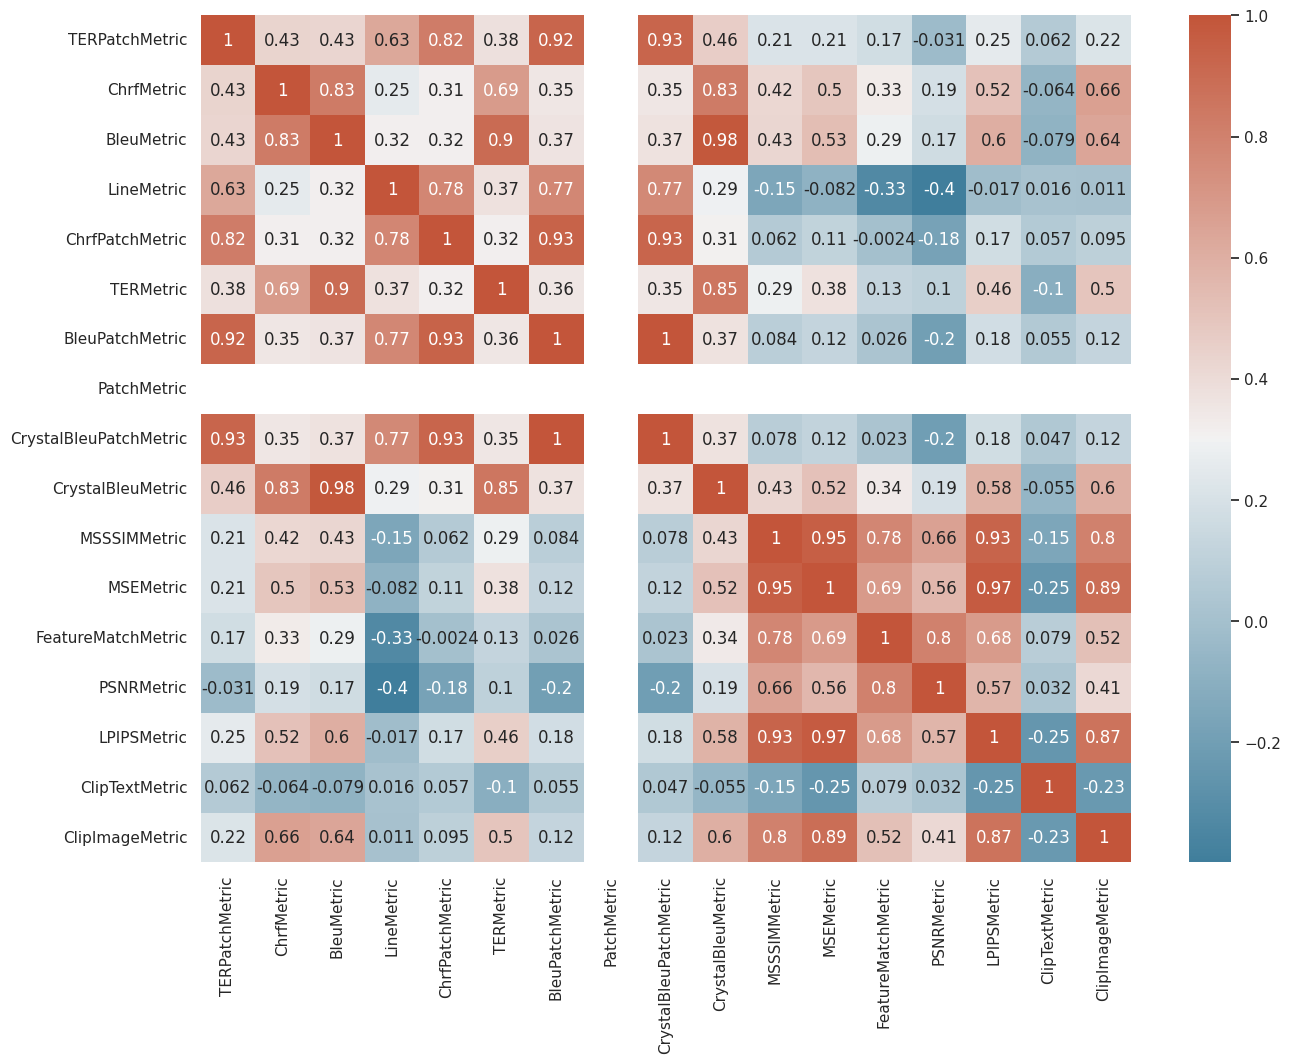

In [102]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = flatten_df.select_dtypes(["int","float"]).corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  cmap=cmap, annot=True)
plt.savefig(os.path.join(result_path,"heatmap_correlation.png"), dpi=300, bbox_inches="tight")


## filtered by difficulty

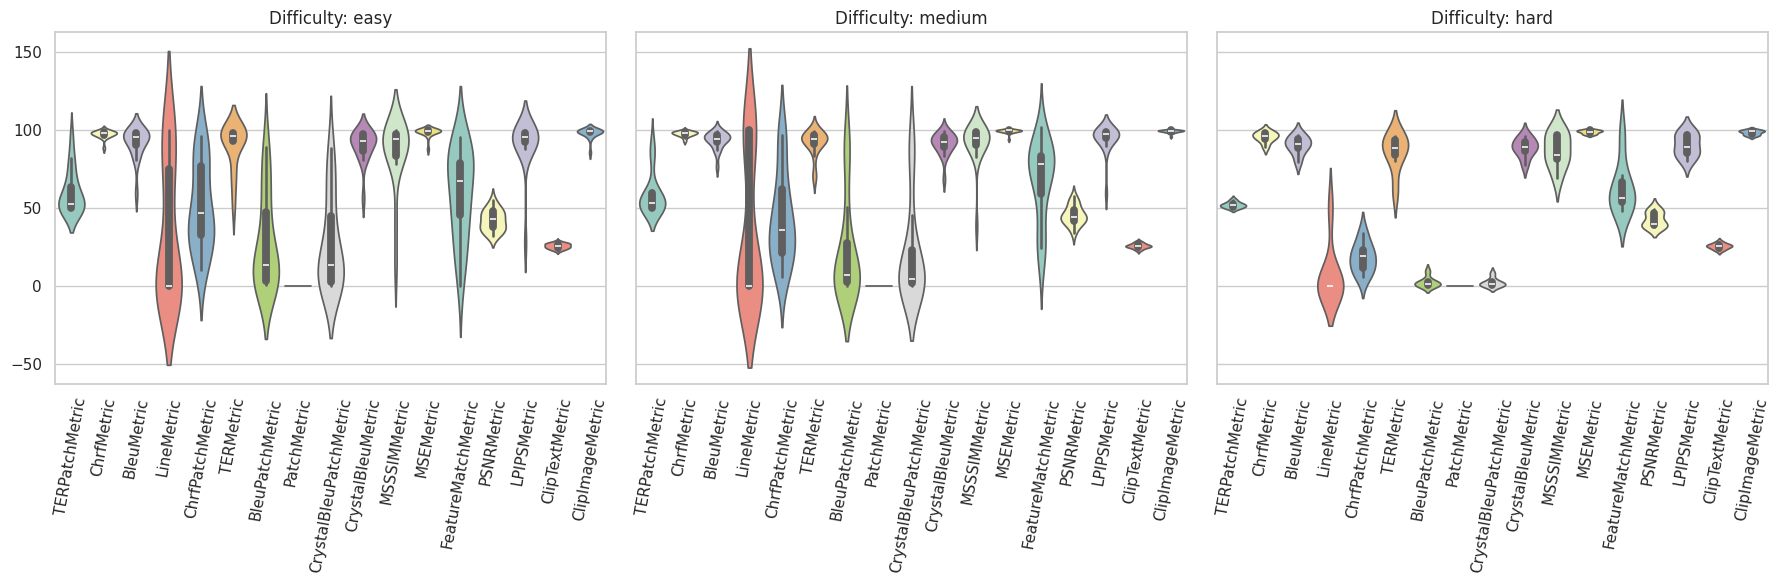

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

df_difficulty = flatten_df.drop("id",axis=1)
df_difficulty

sns.set_theme(style="whitegrid")

# Assuming 'difficulty' column exists in the DataFrame
difficulties = ['easy', 'medium', 'hard']
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Create 3 subplots

for i, difficulty in enumerate(difficulties):
    sns.violinplot(
        data=df_difficulty[df_difficulty['difficulty'] == difficulty], 
        ax=axes[i], 
        palette="Set3"
    )
    axes[i].set_title(f'Difficulty: {difficulty}')
    axes[i].tick_params(axis='x', rotation=80)

plt.tight_layout()
plt.savefig(os.path.join(result_path,"violin_by_difficulty.png"), dpi=300, bbox_inches="tight")
plt.show()


In [104]:
df_difficulty['difficulty'] = pd.Categorical(df_difficulty['difficulty'], categories=['easy', 'medium', 'hard'], ordered=True)
averages = df_difficulty.groupby('difficulty',observed=True).mean()
averages.to_csv(os.path.join(result_path,"avg_by_difficulty.csv"))

averages

,TERPatchMetric,ChrfMetric,BleuMetric,LineMetric,ChrfPatchMetric,TERMetric,BleuPatchMetric,PatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,MSEMetric,FeatureMatchMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric
difficulty,,,,,,,,,,,,,,,,,
easy,60.326481,97.246384,91.829094,34.803925,50.858433,89.589851,27.803858,0.0,27.097240,90.091614,84.950211,98.611443,58.918659,41.999619,90.931831,25.590012,97.977867
medium,58.794704,97.591293,93.304131,34.210526,43.138111,91.718132,21.985466,0.0,20.839909,91.102234,91.620621,99.248177,67.826561,45.357841,94.519554,25.647409,99.201096
hard,51.978725,95.535011,90.366203,7.142857,18.161940,85.720085,2.393253,0.0,2.108735,88.816414,86.990883,98.846786,63.114040,42.577446,90.400391,25.443510,98.438515


In [105]:
med = df_difficulty.groupby('difficulty',observed=True).median()
med.to_csv(os.path.join(result_path,"med_by_difficulty.csv"))
med

,TERPatchMetric,ChrfMetric,BleuMetric,LineMetric,ChrfPatchMetric,TERMetric,BleuPatchMetric,PatchMetric,CrystalBleuPatchMetric,CrystalBleuMetric,MSSSIMMetric,MSEMetric,FeatureMatchMetric,PSNRMetric,LPIPSMetric,ClipTextMetric,ClipImageMetric
difficulty,,,,,,,,,,,,,,,,,
easy,52.272728,97.976738,95.840179,0.0,46.975094,95.975235,13.279688,0.0,13.546466,93.075272,93.994972,99.666069,67.346939,43.175064,95.295769,25.463772,99.210243
medium,53.061226,97.840462,94.180489,0.0,35.941132,94.382019,6.725835,0.0,4.491189,92.330856,95.111641,99.737411,78.260872,44.340443,97.349327,25.416700,99.623383
hard,51.694916,96.329796,91.323776,0.0,18.983681,88.181816,1.241186,0.0,0.910045,89.051842,84.072098,98.936462,56.435642,39.407284,89.420265,25.811075,99.270760
